## MLP for Singapore Airlines Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

### Data Loading

In [2]:
# Load features
X_train = load_npz("data/split/X_train_tfidf.npz")
X_val   = load_npz("data/split/X_val_tfidf.npz")
X_test  = load_npz("data/split/X_test_tfidf.npz")

# Load labels
y_train = pd.read_csv("data/split/train_split.csv")["label"].values
y_val   = pd.read_csv("data/split/val_split.csv")["label"].values
y_test  = pd.read_csv("data/split/test_split.csv")["label"].values

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (7000, 42199) (7000,)
Validation set shape: (1000, 42199) (1000,)
Test set shape: (2000, 42199) (2000,)


In [3]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
label_names = list(le.classes_)
print("Classes:", label_names)

Classes: ['negative', 'neutral', 'positive']


Adjust Class Weights to address imbalance

In [4]:
class_counts = np.bincount(y_train, minlength=3)
class_weights = (class_counts.sum() / (len(class_counts) * np.maximum(class_counts, 1))).astype("float32")
class_weights = torch.tensor(class_weights)

In [5]:
class SparseCSRDataset(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx].toarray().squeeze(0).astype("float32")
        y = np.int64(self.y[idx])
        return x, y
    
train_loader = DataLoader(SparseCSRDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(SparseCSRDataset(X_val, y_val), batch_size=128, shuffle=False)
test_loader = DataLoader(SparseCSRDataset(X_test, y_test), batch_size=128, shuffle=False)

### Define MLP Model (2-Layer)

In [6]:
in_dim = X_train.shape[1]

class MLP(nn.Module):
    def __init__(self, in_dim=in_dim, out_dim=3, hidden=(512, 256), p=0.3):
        super().__init__()
        h1, h2 = hidden
        self.fc1 = nn.Linear(in_dim, h1, bias=True)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1, h2, bias=True)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop = nn.Dropout(p)
        self.fc3 = nn.Linear(h2, out_dim, bias=True)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = self.fc3(x)
        return x

### Model Training and Validation

In [7]:
def train_one_epoch(model, device, optimizer, criterion, train_loader):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data = data.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / max(len(train_loader), 1)
    return model, avg_train_loss

In [8]:
def evaluate(model, device, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_y, all_p = [], []

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device, non_blocking=True).float()
            target = target.to(device, non_blocking=True).long()

            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

            all_y.append(target.cpu().numpy())
            all_p.append(pred.cpu().numpy())

    avg_val_loss = val_loss / max(len(val_loader), 1)

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)
    val_acc = 100.0 * correct / max(total, 1)
    val_macro_f1 = f1_score(y_true, y_pred, average="macro")
    return avg_val_loss, val_acc, val_macro_f1

### Select the best model using Macro-f1 score

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

In [ ]:
best = {"f1_score": -1.0, "accuracy": 0, 
        "cfg": None, "state": None, 
        "train_losses": [], "val_losses": [], 
        "val_accuracies": [], "val_f1s": []}

# Hyperparameter grids
HIDDEN_GRIDS = [
    (256, 128),
    (512, 256),
]
DROPOUTS = [0.1, 0.3, 0.5]
LRS = [0.001, 0.01, 0.1, 0.5, 1.0]
WDS = [0.0, 1e-4, 1e-3]

EPOCHS = 10

for hidden in HIDDEN_GRIDS:
    for p in DROPOUTS:
        for lr in LRS:
            for wd in WDS:
                model = MLP(in_dim=in_dim, out_dim=3, hidden=hidden, p=p)
                model = model.to(device)
                opt = torch.optim.Adadelta(model.parameters(), lr=lr, weight_decay=wd)
                
                train_losses = []
                val_losses = []
                val_accuracies = []
                val_f1s = []
                for epoch in range(1, EPOCHS+1):
                    model, train_loss = train_one_epoch(model, device, opt, criterion, train_loader)
                    val_loss, val_acc, val_f1_score = evaluate(model, device, criterion, val_loader)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    val_accuracies.append(val_acc)
                    val_f1s.append(val_f1_score)
                print(f"[grid] hidden={hidden}, dropout={p}, lr={lr}, wd={wd} -> val macro-F1={val_f1_score:.4f}, val acc={val_acc:.2f}%")
                if val_f1_score > best["f1_score"]:
                    best["f1_score"] = val_f1_score
                    best["accuracy"] = val_acc
                    best["cfg"] = {"hidden": hidden, "dropout": p, "lr": lr, "weight_decay": wd}
                    best["state"] = {k: v.cpu() for k, v in model.state_dict().items()}
                    best["train_losses"] = train_losses
                    best["val_losses"] = val_losses
                    best["val_accuracies"] = val_accuracies
                    best["val_f1s"] = val_f1s
print("\nBest validation macro-F1:", round(best["f1_score"], 4))
print("\nBest validation accuracy:", round(best["accuracy"], 2), "%")
print("\nBest config:", best["cfg"])


Best validation macro-F1: 0.7243

Best validation accuracy: 85.0 %

Best config: {'hidden': (512, 256), 'dropout': 0.1, 'lr': 0.01, 'weight_decay': 0.001}


In [15]:
# Print training and validation process of best model
for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}: Train Loss={best['train_losses'][epoch-1]:.4f}, Val Loss={best['val_losses'][epoch-1]:.4f}, Val Acc={best['val_accuracies'][epoch-1]:.2f}%, Val Macro-F1={best['val_f1s'][epoch-1]:.4f}")

Epoch 1: Train Loss=1.0224, Val Loss=1.0855, Val Acc=73.90%, Val Macro-F1=0.2833
Epoch 2: Train Loss=0.6650, Val Loss=0.8110, Val Acc=76.20%, Val Macro-F1=0.6223
Epoch 3: Train Loss=0.4793, Val Loss=0.7238, Val Acc=77.50%, Val Macro-F1=0.6436
Epoch 4: Train Loss=0.3555, Val Loss=0.6911, Val Acc=78.90%, Val Macro-F1=0.6646
Epoch 5: Train Loss=0.2624, Val Loss=0.6741, Val Acc=80.70%, Val Macro-F1=0.6790
Epoch 6: Train Loss=0.1893, Val Loss=0.6586, Val Acc=81.30%, Val Macro-F1=0.6883
Epoch 7: Train Loss=0.1425, Val Loss=0.6553, Val Acc=82.70%, Val Macro-F1=0.7003
Epoch 8: Train Loss=0.1058, Val Loss=0.6533, Val Acc=83.30%, Val Macro-F1=0.7026
Epoch 9: Train Loss=0.0796, Val Loss=0.6483, Val Acc=83.80%, Val Macro-F1=0.7068
Epoch 10: Train Loss=0.0604, Val Loss=0.6537, Val Acc=85.00%, Val Macro-F1=0.7243


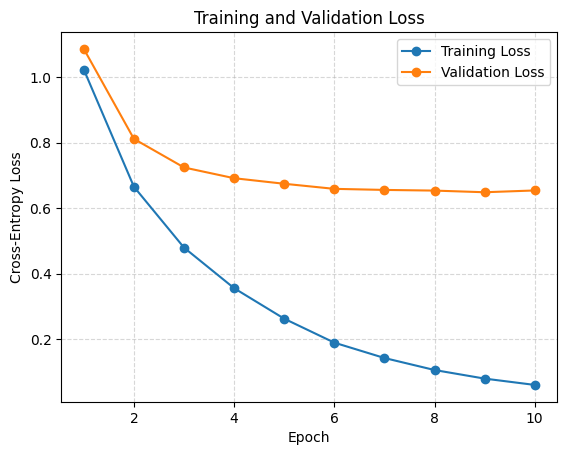

In [16]:
# Plot training and validation loss curves
plt.plot(range(1, EPOCHS+1), best["train_losses"], label='Training Loss', marker="o")
plt.plot(range(1, EPOCHS+1), best["val_losses"],   label='Validation Loss', marker="o")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Cross-Entropy Loss')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Evaluate Final Best Model

In [20]:
best_model = MLP(in_dim=in_dim, out_dim=3, hidden=best["cfg"]["hidden"], p=best["cfg"]["dropout"])
best_model.load_state_dict(best["state"])

for param_tensor in best_model.state_dict():
  print(param_tensor, ":", model.state_dict()[param_tensor].size())

fc1.weight : torch.Size([512, 42199])
fc1.bias : torch.Size([512])
bn1.weight : torch.Size([512])
bn1.bias : torch.Size([512])
bn1.running_mean : torch.Size([512])
bn1.running_var : torch.Size([512])
bn1.num_batches_tracked : torch.Size([])
fc2.weight : torch.Size([256, 512])
fc2.bias : torch.Size([256])
bn2.weight : torch.Size([256])
bn2.bias : torch.Size([256])
bn2.running_mean : torch.Size([256])
bn2.running_var : torch.Size([256])
bn2.num_batches_tracked : torch.Size([])
fc3.weight : torch.Size([3, 256])
fc3.bias : torch.Size([3])


In [21]:
# Save best model
torch.save(best_model.state_dict(), "best_mlp_model.pth")

In [18]:
def loader_preds(model, loader, device):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device).long()
            pred = model(xb).argmax(1)
            ys.append(yb.cpu().numpy())
            ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return y_true, y_pred

### Test Report

In [19]:
y_test_true, y_test_pred = loader_preds(best_model, test_loader, device)
test_acc = accuracy_score(y_test_true, y_test_pred)
test_macro_f1 = f1_score(y_test_true, y_test_pred, average="macro")
print(f"\nTest Accuracy: {test_acc:.4f}")
print("\nTest classification report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_names, digits=4))
print("\nTest confusion matrix:\n", confusion_matrix(y_test_true, y_test_pred))


Test Accuracy: 0.8405

Test classification report:
              precision    recall  f1-score   support

    negative     0.6965    0.7531    0.7237       320
     neutral     0.4082    0.5396    0.4648       202
    positive     0.9596    0.9005    0.9291      1478

    accuracy                         0.8405      2000
   macro avg     0.6881    0.7311    0.7059      2000
weighted avg     0.8618    0.8405    0.8494      2000


Test confusion matrix:
 [[ 241   65   14]
 [  51  109   42]
 [  54   93 1331]]
